# IJO detection by AutoEncoder

## 参考
* https://www.slideshare.net/KazukiMotohashi2/20190619-150591242
* http://data-analysis-stats.jp/2020/01/03/keras-autoencoder-%E3%81%A7%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5%E3%80%8C%E8%A9%90%E6%AC%BA%E6%A4%9C%E7%9F%A5%E3%80%8D/

# 実装

In [1]:
from keras.models import Model, model_from_json
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam

Using TensorFlow backend.


## データ読み込み

In [2]:
rng = np.random.RandomState(42)

n_feat = 2
# Generate train data
X = 0.3 * rng.randn(100, n_feat)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, n_feat)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, n_feat))

## モデル作成 

* 2-2-2       : loss=  0.05940939903259277
* 2-2-2-2-2   : loss=  0.050861050486564634
* 2-32-2-32-2 : loss= 

* 中間層の出力の取得方法：https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer


In [3]:
encoding_dim = 2
hidden_dim = 2
input_layer = Input(shape=(n_feat,))
encoded = Dense(hidden_dim, activation='sigmoid')(input_layer)
#encoded = Dense(encoding_dim, activation='sigmoid', name='encoder')(input_layer) # For 3 Layers

encoded = Dense(encoding_dim, activation='sigmoid', name='encoder')(encoded)
decoded = Dense(hidden_dim, activation='sigmoid')(encoded)

decoded = Dense(n_feat )(decoded)
#decoded = Dense(n_feat)(encoded) # For 3 Layers. activation=linear


autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

autoencoder.summary()





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
encoder (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6         
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [4]:
nb_epoch = 600
batch_size = 32

history = autoencoder.fit(X_train, X_train,
   epochs=nb_epoch,
                          
   batch_size=batch_size,
   validation_data=(X_test, X_test), verbose=False)


loss=  0.07767715156078339


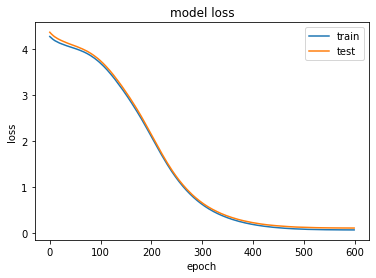

In [5]:
print( "loss= ", history.history['loss'][-1])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [6]:
def mse( xx ):
    return np.mean( xx**2, axis=1 )

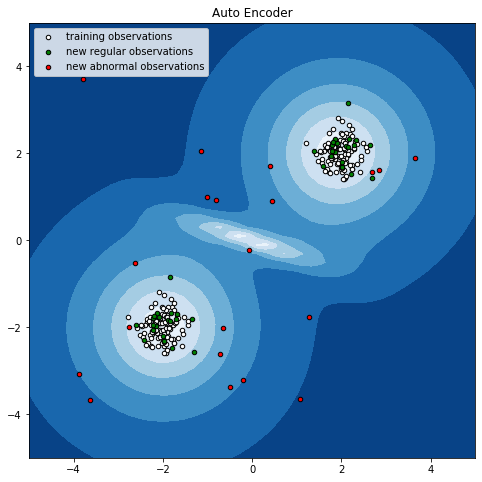

In [7]:
# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
xxyy = np.c_[xx.ravel(), yy.ravel()]
Z = autoencoder.predict(xxyy)
Z = mse(Z - xxyy)
Z = 1 / ( 1 + Z.reshape(xx.shape) ) # 1:normal, 0:abnormal

plt.figure( figsize=[8,8])
plt.title("Auto Encoder")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")

plt.show()

## 推定値とエンコード値の計算

In [8]:
y_pred_train = autoencoder.predict( X_train )
y_pred_test = autoencoder.predict( X_test )
y_pred_outliers = autoencoder.predict( X_outliers )

e_train = encoder.predict( X_train )
e_test = encoder.predict( X_test )
e_outliers = encoder.predict( X_outliers)

In [44]:
def plot_encoded_predicted( e_train, y_pred_train, X_train ):
    plt.figure(figsize=[14,6])
    plt.subplot(221)
    plt.imshow( e_train.T, cmap='copper', aspect=10 )
    plt.title('Encoded values. node vs samples')
    plt.subplot(222)
    plt.plot(e_train, 'o--' )
    plt.xlim([0,e_train.shape[0]])
    plt.title('Encoded values. value vs samples')
    plt.subplot(223)
    plt.plot(y_pred_train, 'o--' )
    plt.xlim([0,e_train.shape[0]])
    plt.ylim([-3,3])
    plt.title('Predicted vs samples')
    plt.subplot(224)
    plt.plot(X_train, 'o--')
    plt.xlim([0,e_train.shape[0]])
    plt.title('True vs samples')
    plt.tight_layout()

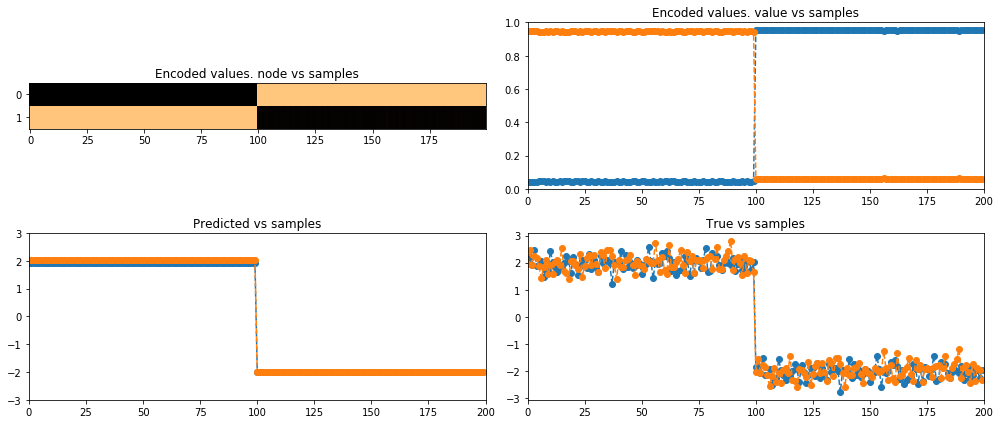

In [43]:
plot_encoded_predicted( e_train, y_pred_train, X_train)

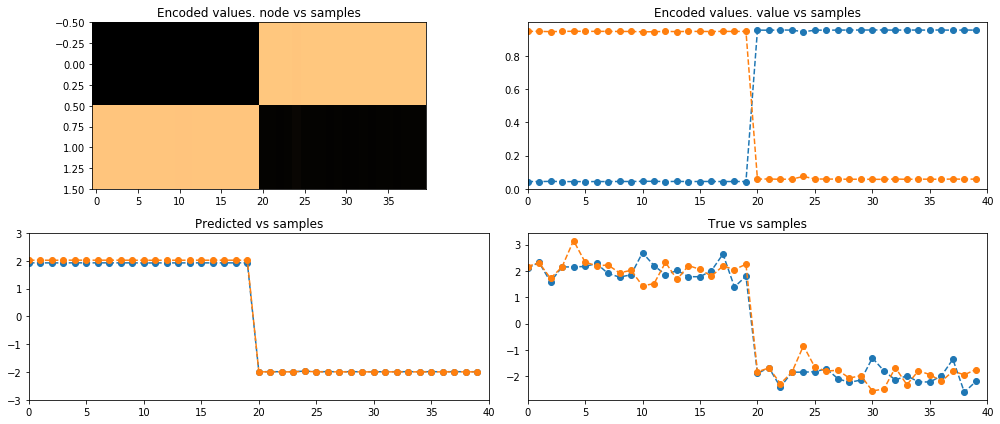

In [45]:
plot_encoded_predicted( e_test, y_pred_test, X_test)

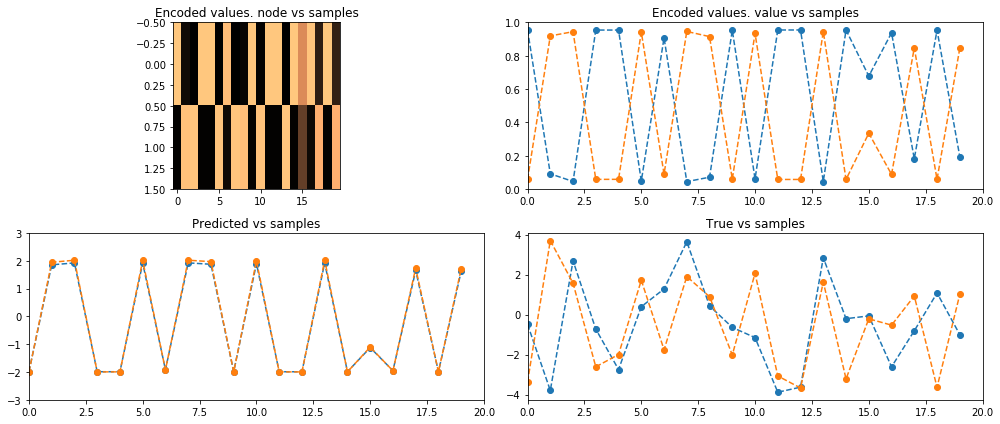

In [42]:
plot_encoded_predicted( e_outliers, y_pred_outliers, X_outliers)

## スコアの計算

In [10]:
scr_train = 1 / ( 1 + mse( X_train - y_pred_train ) )
scr_test = 1 / ( 1 + mse( X_test - y_pred_test) )
scr_outliers = 1 / ( 1 + mse( X_outliers - y_pred_outliers ) )

## 閾値の調整

|th | F1 |
|:---|:---|
|0.45 |61.5|
|0.4  |66.7|
|0.35 |66.7|
|0.3  |60.0|

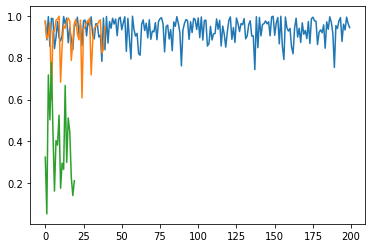

In [11]:
th =  0.4
res_train = np.ones_like( scr_train, dtype=np.int16 )
res_train[scr_train < th] = -1
res_test = np.ones_like( scr_test, dtype=np.int16 )
res_test[scr_test < th] = -1
res_outliers = np.ones_like( scr_outliers, dtype=np.int16 )
res_outliers[scr_outliers < th] = -1

plt.plot( scr_train )
plt.plot( scr_test )
plt.plot( scr_outliers )

In [12]:
from matplotlib.colors import Normalize

def plot_true_false( data, result, score, vmax=None, vmin=None ):
    res_minus = ( result < 0 )
    res_plus = ( result > 0 )

    norm=Normalize(vmin=vmin, vmax=vmax)

    plt.figure( figsize=[10,6] )
    plt.scatter( data[res_plus,0], data[res_plus,1], c=score[res_plus], s=10, norm=norm )
    plt.scatter( data[res_minus,0], data[res_minus,1], c=score[res_minus], marker='x',norm=norm )
    plt.colorbar()

In [13]:
X_all = np.concatenate( ( X_train, X_test, X_outliers ) )
scr_all = np.concatenate( ( scr_train, scr_test, scr_outliers ) )
res_all = np.concatenate( ( res_train, res_test, res_outliers ) )

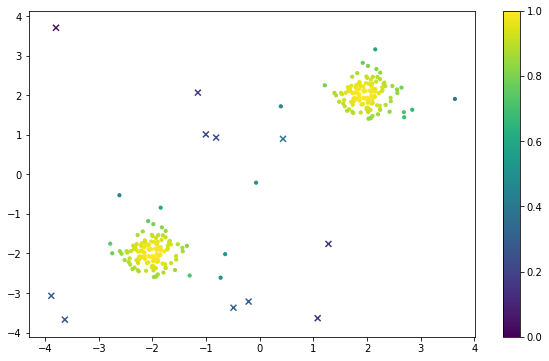

In [14]:
plot_true_false( X_all, res_all, scr_all, vmax=1.0, vmin=0.0)

In [15]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

In [16]:
ans_test = np.ones_like( res_test )
ans_outliers = np.ones_like( res_outliers ) *  -1
ans_eval = np.concatenate( (ans_test, ans_outliers ))
res_eval = np.concatenate( (res_test, res_outliers ))

In [17]:
confmat = confusion_matrix( y_true=ans_eval, y_pred=res_eval, labels=[-1,1] )
accuracy = accuracy_score( y_true=ans_eval, y_pred=res_eval )
precision = precision_score( y_true=ans_eval, y_pred=res_eval, pos_label=-1 )
recall = recall_score( y_true=ans_eval, y_pred=res_eval, pos_label=-1 )
f1 = f1_score( y_true=ans_eval, y_pred=res_eval, pos_label=-1 )

print( confmat )
print( "accuracy  %.1f%%" % (accuracy*100) )
print( "precision %.1f%%" % (precision*100) )
print( "recall    %.1f%%" % (recall*100 ) )
print( "f1        %.1f%%" % (f1*100) )

[[11  9]
 [ 0 40]]
accuracy  85.0%
precision 100.0%
recall    55.0%
f1        71.0%


In [18]:
import seaborn as sns

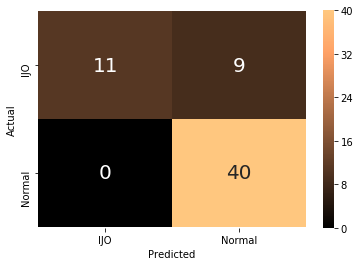

In [19]:
def plot_confusion_matrix( confmat, label=['IJO', 'Normal']):
    from matplotlib import __version__
    ax = sns.heatmap(confmat,annot=True, cmap=plt.cm.copper, annot_kws={'size':20})    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels( label )
    ax.set_yticklabels( label )
    if __version__ == '3.1.1':
        ax.set_ylim(len(confmat)+0.01,-0.01) # WA for ver 3.1.1 bug    
        
plot_confusion_matrix( confmat )

In [20]:
#%qtconsole

In [21]:
a = np.array([[2,-2],[2,-2]])
ainv = np.linalg.pinv(a)
a.dot(ainv)

array([[0.5, 0.5],
       [0.5, 0.5]])